# Calibrating the HMETS hydrological model using OSTRICH on the Raven server

Here we use birdy's WPS client to calibrate the HMETS hydrological model on the server and analyze the calibrated parameter set and hydrograph. 

In [11]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

url = "http://localhost:9099/wps"
wps = WPSClient(url)

In [32]:
# The model parameter boundaries. Can either be a string of comma separated values, a list, an array or a named tuple. 
lowerBounds = '0.3, 0.01, 0.5, 0.15, 0.0, 0.0, -2.0, 0.01, 0.0, 0.01, 0.005, -5.0, \
                      0.0, 0.0, 0.0, 0.0, 0.00001, 0.0, 0.00001, 0.0, 0.0'
upperBounds = '20.0, 5.0, 13.0, 1.5, 20.0, 20.0, 3.0, 0.2, 0.1, 0.3, 0.1, 2.0, 5.0, \
                      1.0, 3.0, 1.0, 0.02, 0.1, 0.01, 0.5, 2.0'
          
# Forcing files
ts=TESTDATA['ostrich-hmets-nc-ts']

# OSTRICH configuration parameters
config = dict(
    algorithm='DDS',
    max_iterations=10,
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    lowerbounds=lowerBounds,
    upperbounds=upperBounds,
    start_date=dt.datetime(1954, 1, 1),
    duration=208,
    )

# Let's call Ostrich with the timeseries, calibration parameters and other configuration parameters
resp = wps.ostrich_hmets(ts=str(ts), **config)

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally. 
[calibration, hydrograph, storage, solution, diagnostics] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file: 

In [33]:
print(diagnostics)

observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,
HYDROGRAPH,./model//Salmon-River-Near-Prince-George_meteo_daily.nc,-0.686583,67.2876,



The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [29]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 209, nbasins: 1)>
array([[  0.      ],
       [317.767047],
       [602.685996],
       ...,
       [ 16.700328],
       [ 55.739867],
       [101.356578]])
Coordinates:
  * time        (time) datetime64[ns] 1954-01-01 1954-01-02 1954-01-03 ...
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

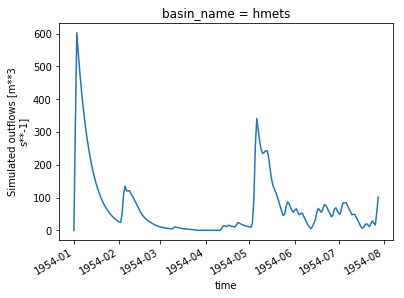

In [30]:
hydrograph.q_sim.plot()

In [31]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby('time.month').mean())

Max:  <xarray.DataArray 'q_sim' ()>
array(602.685996)
Mean:  <xarray.DataArray 'q_sim' ()>
array(71.840511)
Monthly means:  <xarray.DataArray 'q_sim' (month: 7)>
array([190.565714,  60.216904,   5.036852,   9.51106 , 139.359067,  48.586079,
        42.923882])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7
